# Glam model simulations tests 

## Import components

In [1]:
import glam
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt


from scipy.stats import invgauss

import seaborn as sns
import matplotlib.pyplot as plt
plt.switch_backend('agg')

from scipy import stats


In [2]:
import warnings
warnings.filterwarnings('ignore')


In [3]:
np.random.seed(23) # from random.org

In [4]:
sufix = '_Like_FixBin5'

## Attempt with individual model data

Loading results from model constructed from Like condition, all participants.

In [5]:
data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_Like_Bin_v2.csv'))
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]

In [6]:
glam_full = glam.GLAM(data)
glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)

Generating single subject models for 33 subjects...


In [7]:
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_individual'+sufix+'.npy'))

In [8]:
#glam_full.estimates

In [9]:
# We can define n_repeats (1 by default), boundary (1 by default), error_weight ( 0.05 by default) 
#glam_full.predict(n_repeats=50)


In [ ]:
## Select one participants parameters to perform the simulations
subject = 0
parameters = [glam_full.estimates[subject].get(parameter)
                              for parameter in ['v', 'gamma', 's', 'tau', 't0']]
parameters

In [11]:
value_cols = ['item_value_{}'.format(i)
                          for i in range(glam_full.n_items)]
gaze_cols = ['gaze_{}'.format(i)
                         for i in range(glam_full.n_items)]

In [12]:
values = glam_full.data[value_cols][glam_full.data['subject'] == subject].values
gaze = glam_full.data[gaze_cols][glam_full.data['subject'] == subject].values

rt_min = glam_full.data['rt'][glam_full.data['subject'] == subject].values.min()
rt_max = glam_full.data['rt'][glam_full.data['subject'] == subject].values.max()
error_range = (rt_min, rt_max)

In [13]:
# Parameters for the simulations
n_repeats=50
boundary=1
error_weight=0.05

# Variables to run the simulation (repetitions give by n_repeats) for various trials
n_trials, n_items = values.shape
rts = np.zeros(n_trials * n_repeats) * np.nan
choices = np.zeros(n_trials * n_repeats) * np.nan
trial_idx = np.zeros(n_trials * n_repeats) * np.nan
repeat_idx = np.zeros(n_trials * n_repeats) * np.nan

running_idx = 0


In [14]:
## To run the simulations to various trials (e.g. all trials from subject s)

for trial in range(n_trials):

        for repeat in range(n_repeats):

            choice, rt = glam.simulation.simulate_trial(parameters, values[trial], gaze[trial],
                                        boundary=boundary,
                                        error_weight=error_weight,
                                        error_range=error_range)

            rts[running_idx] = rt
            choices[running_idx] = choice
            trial_idx[running_idx] = trial
            repeat_idx[running_idx] = repeat

            running_idx += 1

## Simulation of individual trial
 Evidence_item_1 (t) = Evidence_item_1 (t-1) + v*R_i + GaussNoise + t0
 
 Drift function delivers the component v*R_i from the accumulutaion equation
 
 FPTs[i] = invgauss.rvs(mu=mu/lam, scale=lam) defines a random sample from a distribution (inverse Gaussian) containing the time of first hit in a barrier for an accumulator (as the ones given by Evidence_item_1). FPTs value for each item. Considering the item with the min(FPT + t0) we define choice and RT. Item with lower FPT value is the one chosen in that trial. 

In [15]:
# using trial 1 for participant selected
trial = 1
value_trial = values[trial]
gaze_trial = gaze[trial]

v, gamma, s, tau, t0 = parameters
n_items = len(values[trial])


# including in the model possibility of random answer (and random RT)
if np.random.uniform(0, 1) < error_weight:
    rt = int(np.random.uniform(*error_range))
    choice = np.random.choice(n_items)
else:
    drifts = glam.simulation.expdrift(v, tau, gamma, value_trial, gaze_trial)
    FPTs = np.zeros(n_items) * np.nan
    for i in range(n_items):
        mu = boundary / drifts[i]
        lam = (boundary / s)**2
        FPTs[i] = invgauss.rvs(mu=mu/lam, scale=lam)
    choice = np.argmin(FPTs)
    rt = int(np.round(np.min(FPTs) + t0))

print([choice, rt])

[0, 1254]


## Simulate trials with selected value conditions

### Using DV = 1 but with different value magnitude

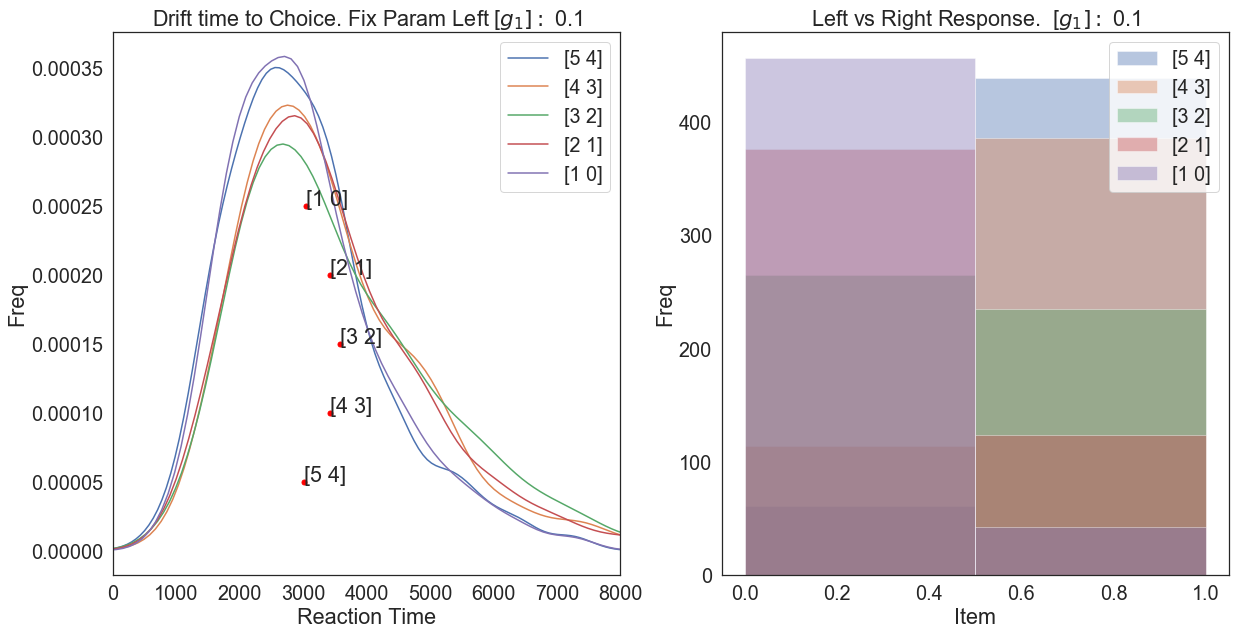

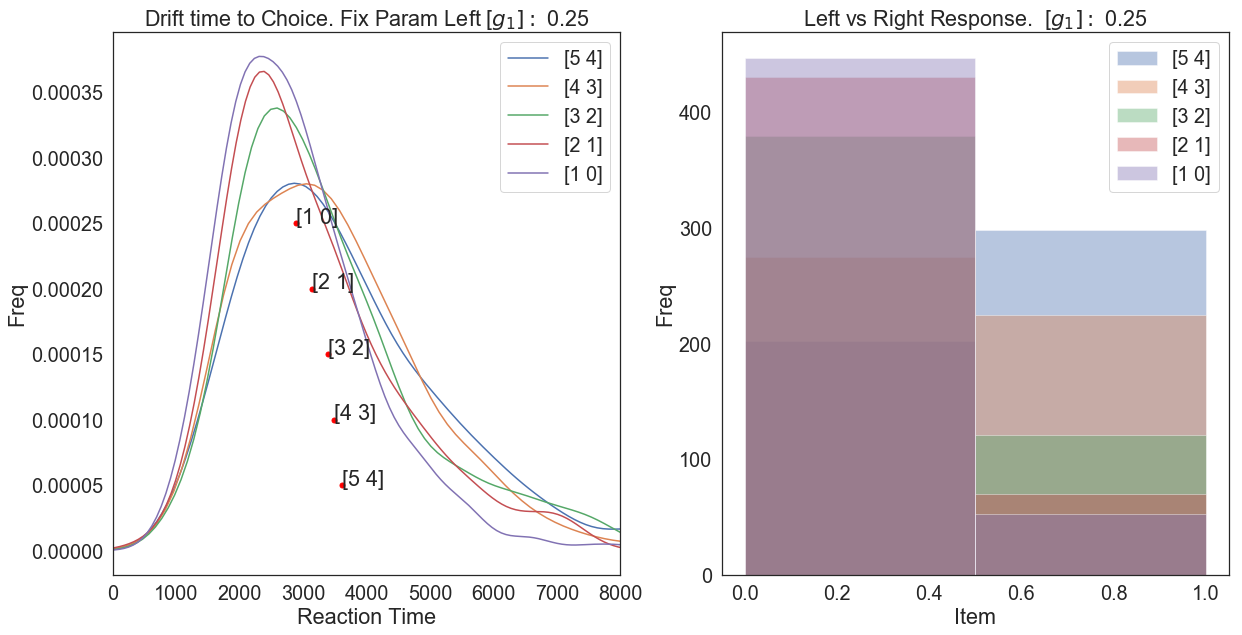

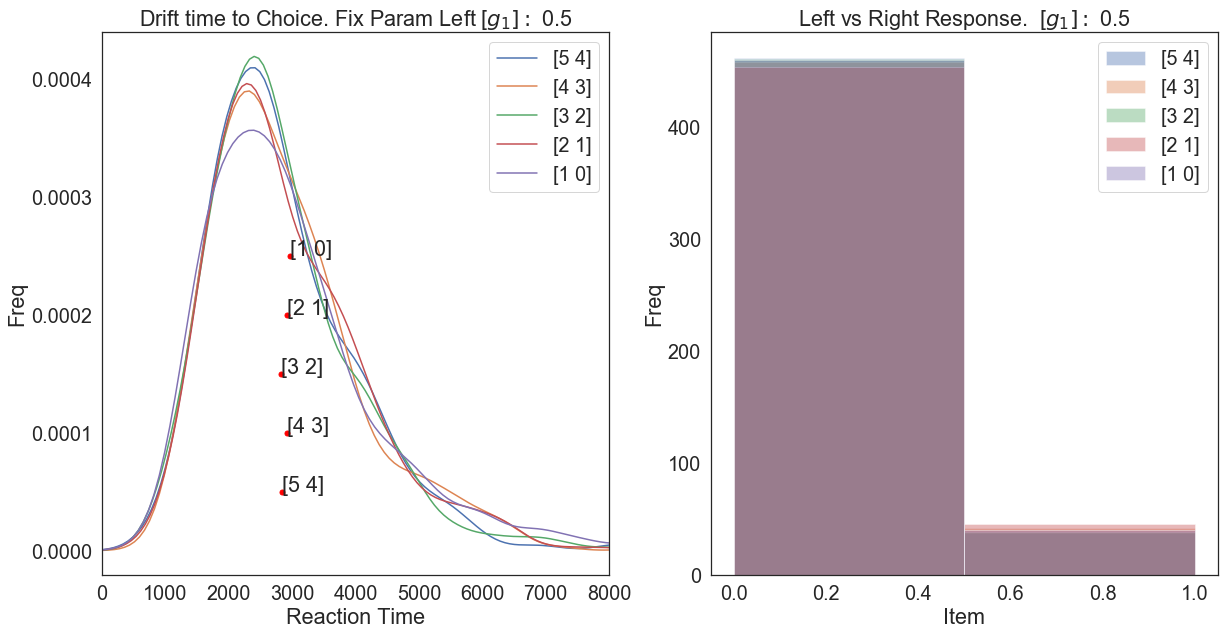

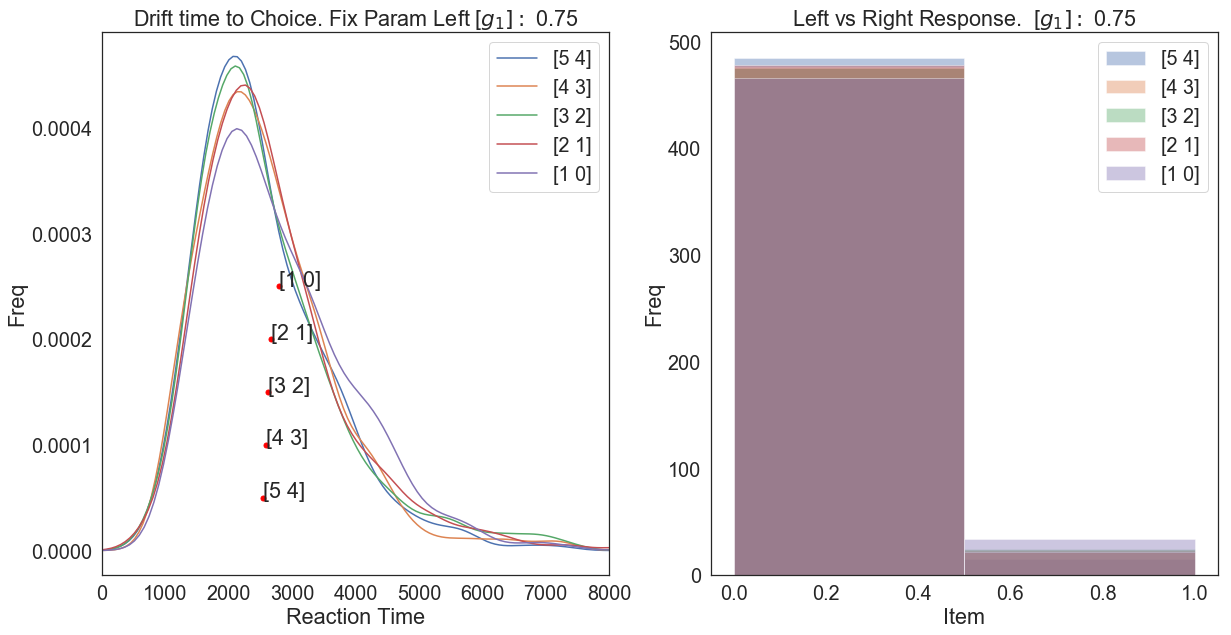

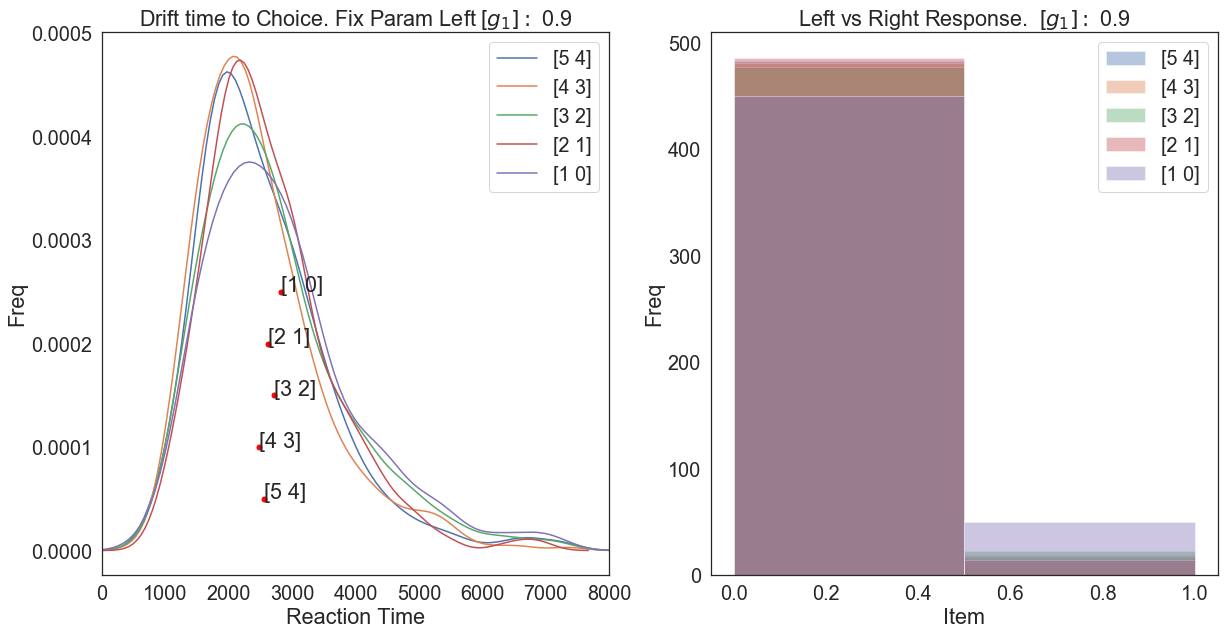

In [16]:
value_tests = np.array([[5,4],[4,3],[3,2],[2,1],[1,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 500



# iteration for gaze levels

for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)
    n_trials, n_items = value_tests.shape

    # Iteration for trial value pairs
    for trial in range(n_trials):
        
        #initialize the vectors containing results from the simulation
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
        
        # run n_repeats simulations for each selected trial 
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                # code to run simulations
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
                # organize results in a matrix
                
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                running_idx += 1
                
        # Calculate mean value for reaction times        
        
        mean_rts =  rts.mean()
            
        # Plot for this individual trial
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.plot([mean_rts], [0.00005 + 0.00005*trial], marker='o', markersize=5, color="red")
        plt.text(mean_rts,0.00005 + 0.00005*trial, str(value_trial))

        
        
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



### Using various DVs 

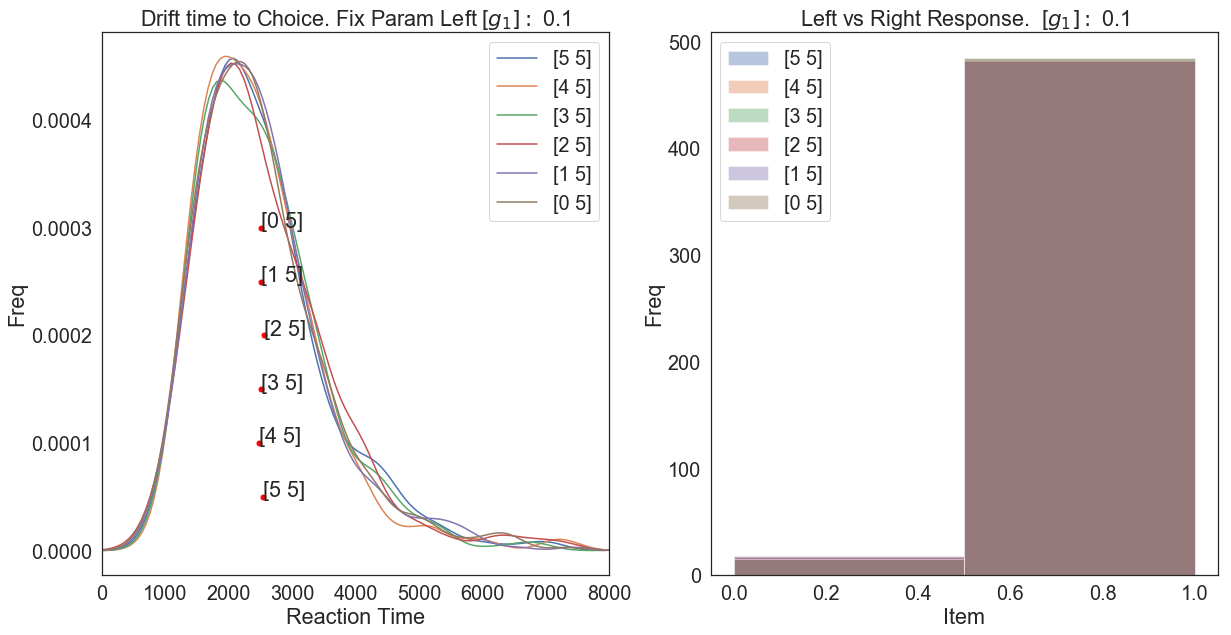

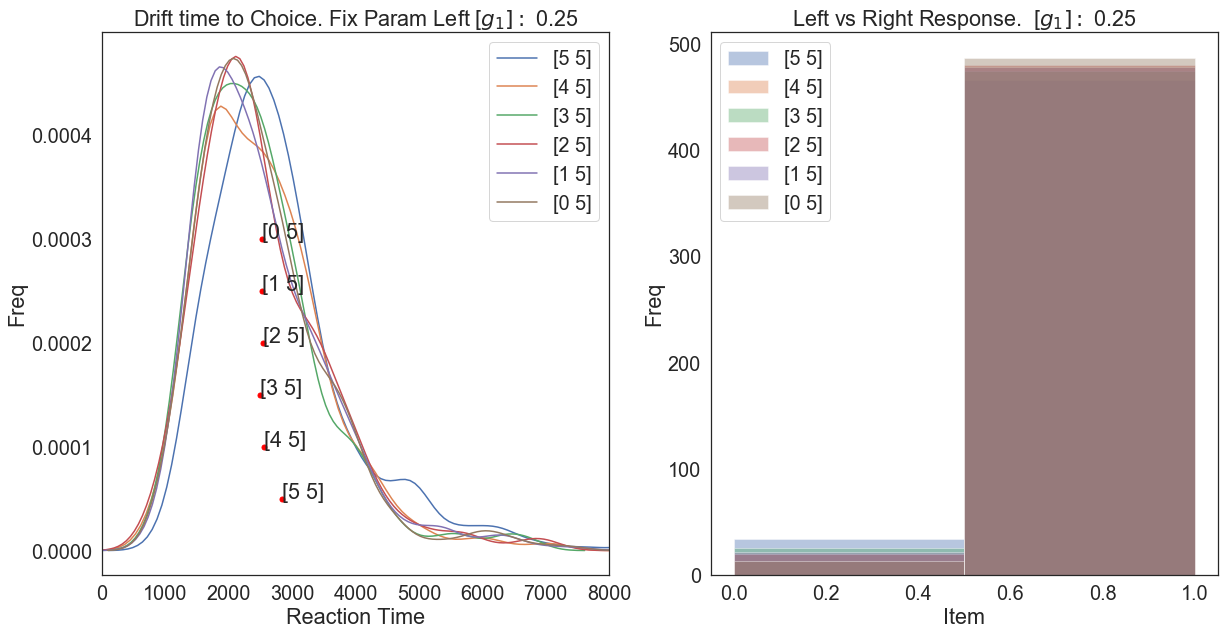

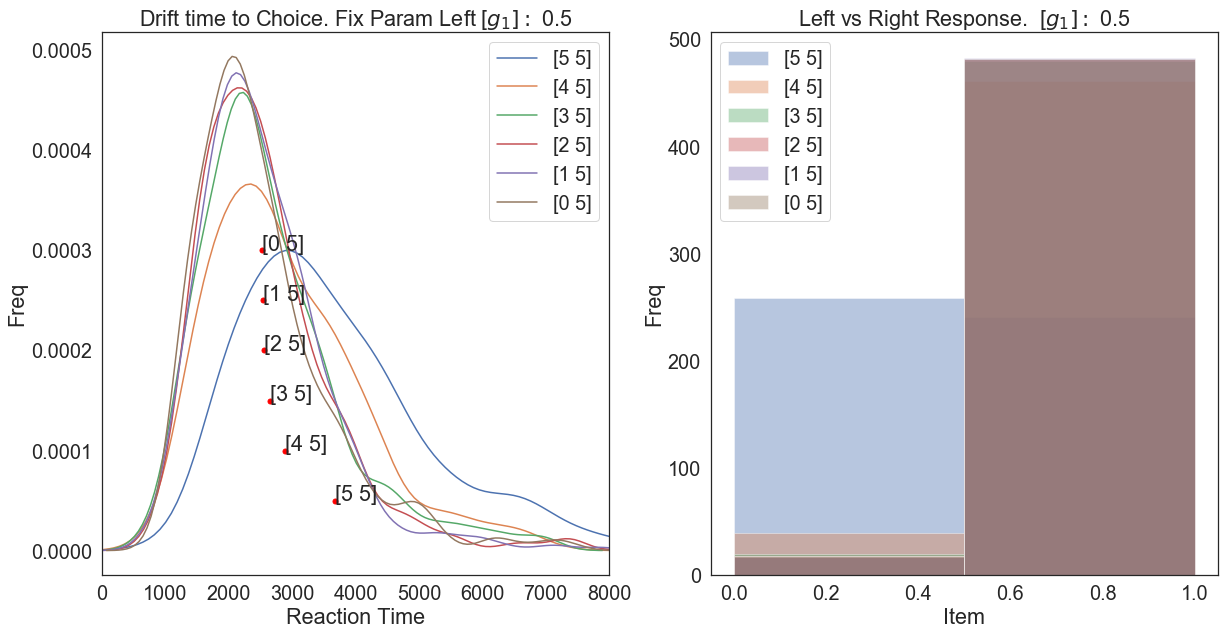

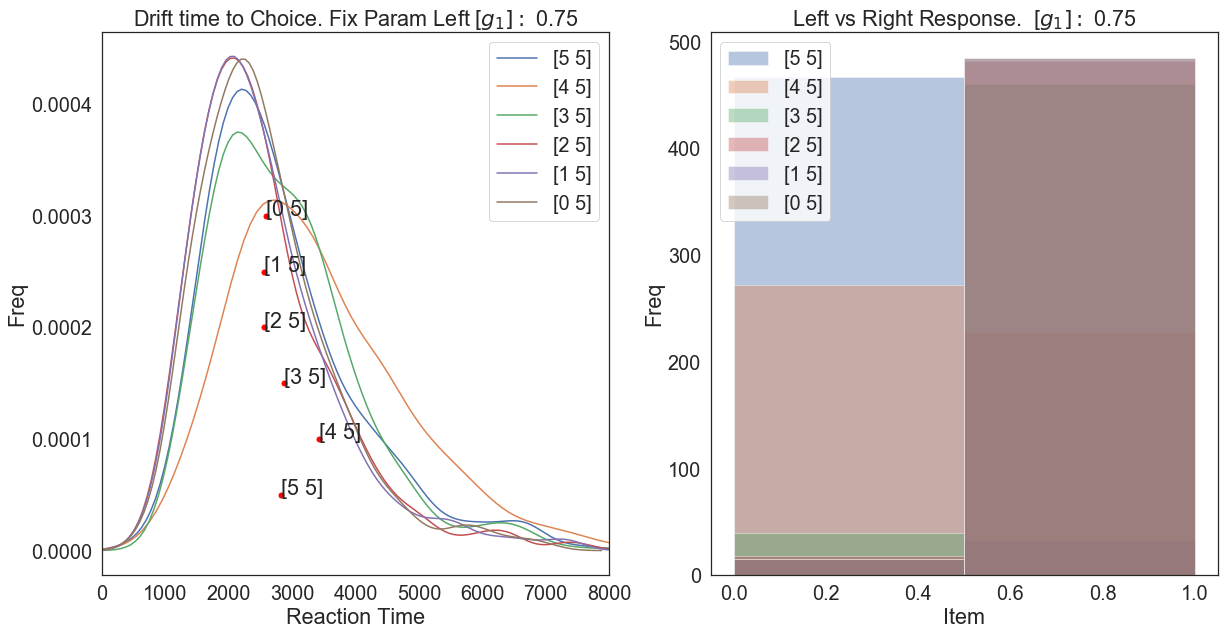

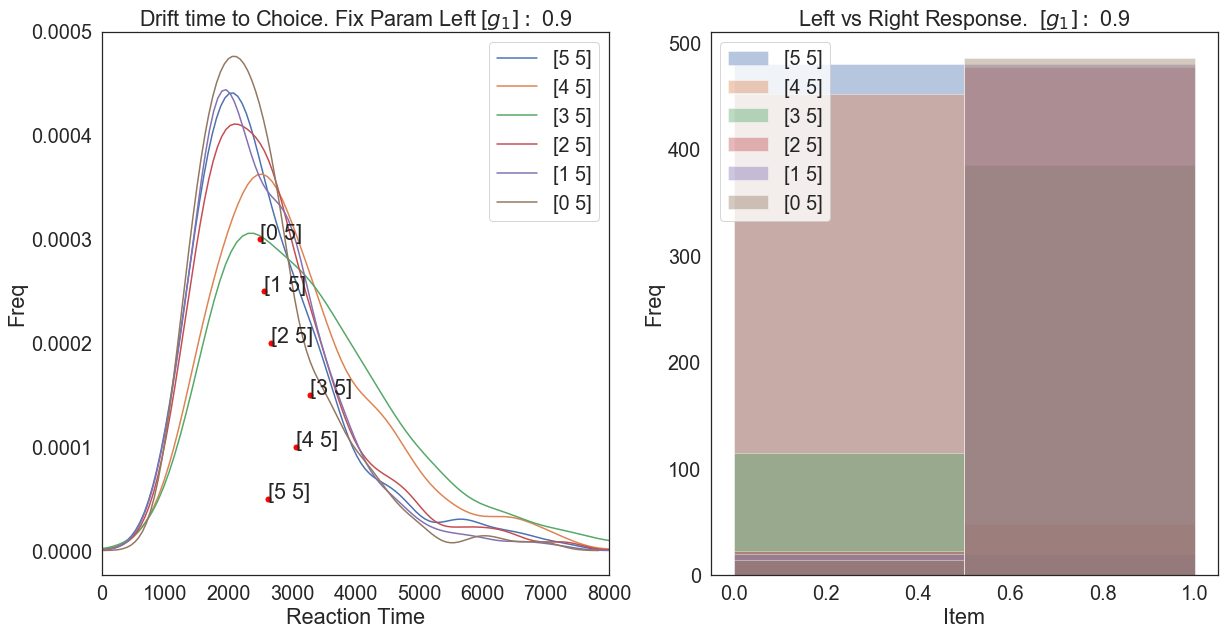

In [17]:
value_tests = np.array([[5,5],[4,5],[3,5],[2,5],[1,5],[0,5]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 500




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)

    n_trials, n_items = value_tests.shape
    
    for trial in range(n_trials):
    
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
        # Calculate mean value for reaction times             
        mean_rts =  rts.mean()
            
        # Plot for this individual trial
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.plot([mean_rts], [0.00005 + 0.00005*trial], marker='o', markersize=5, color="red")
        plt.text(mean_rts,0.00005 + 0.00005*trial, str(value_trial))
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



## Using DV = 0 at different value magnitudes

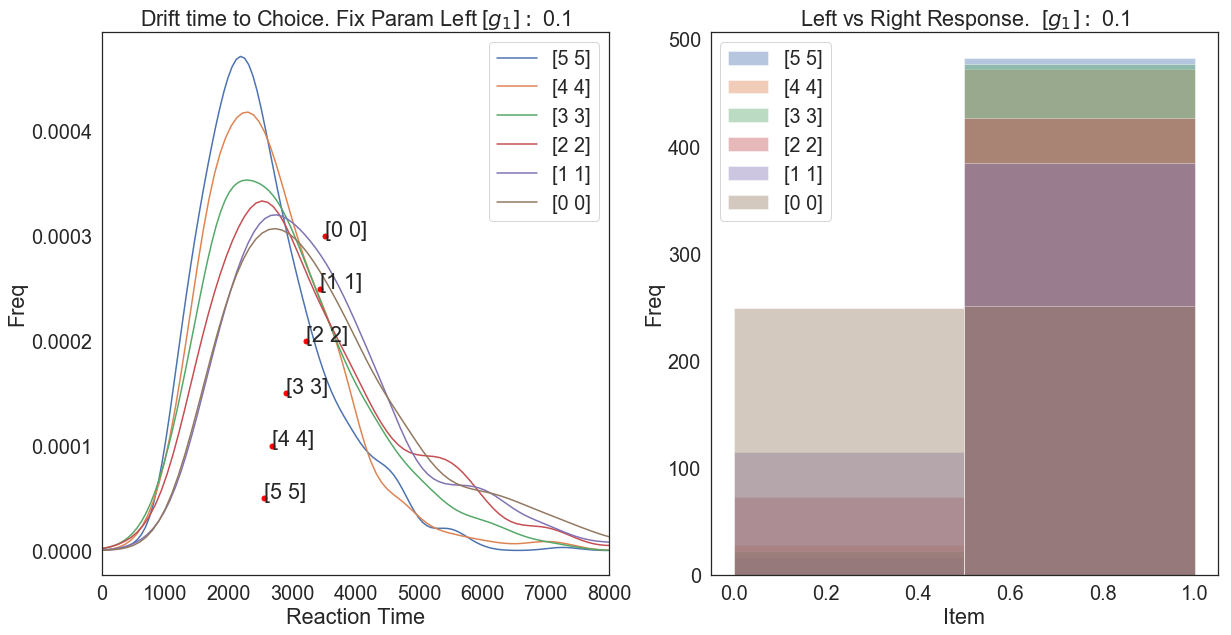

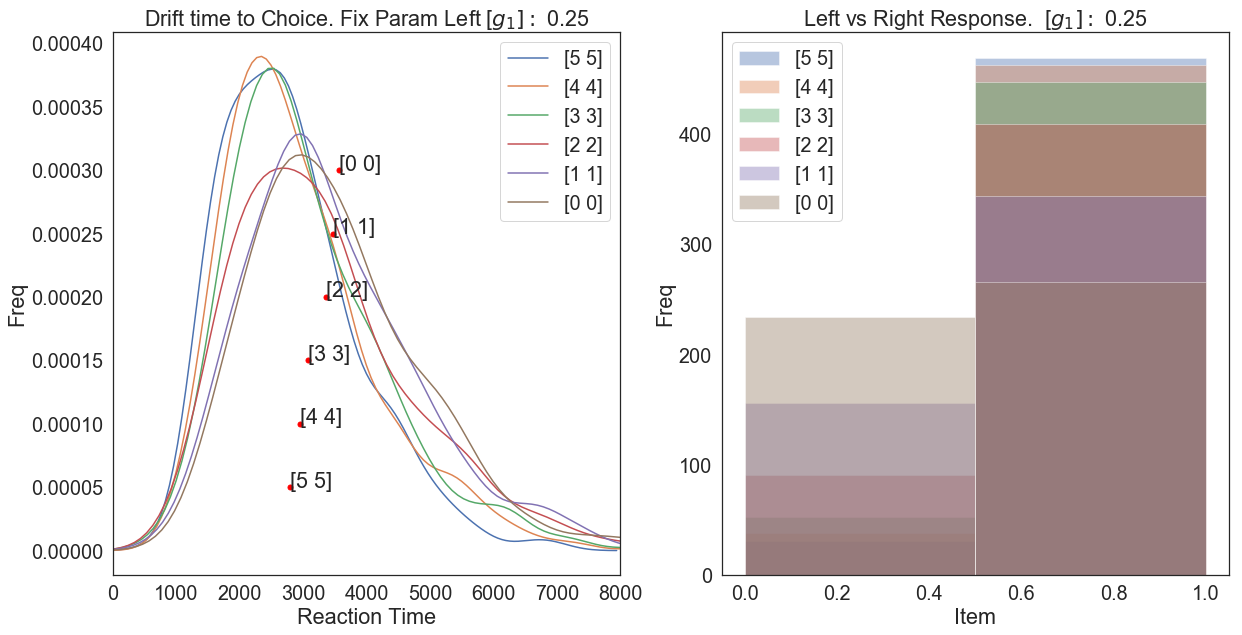

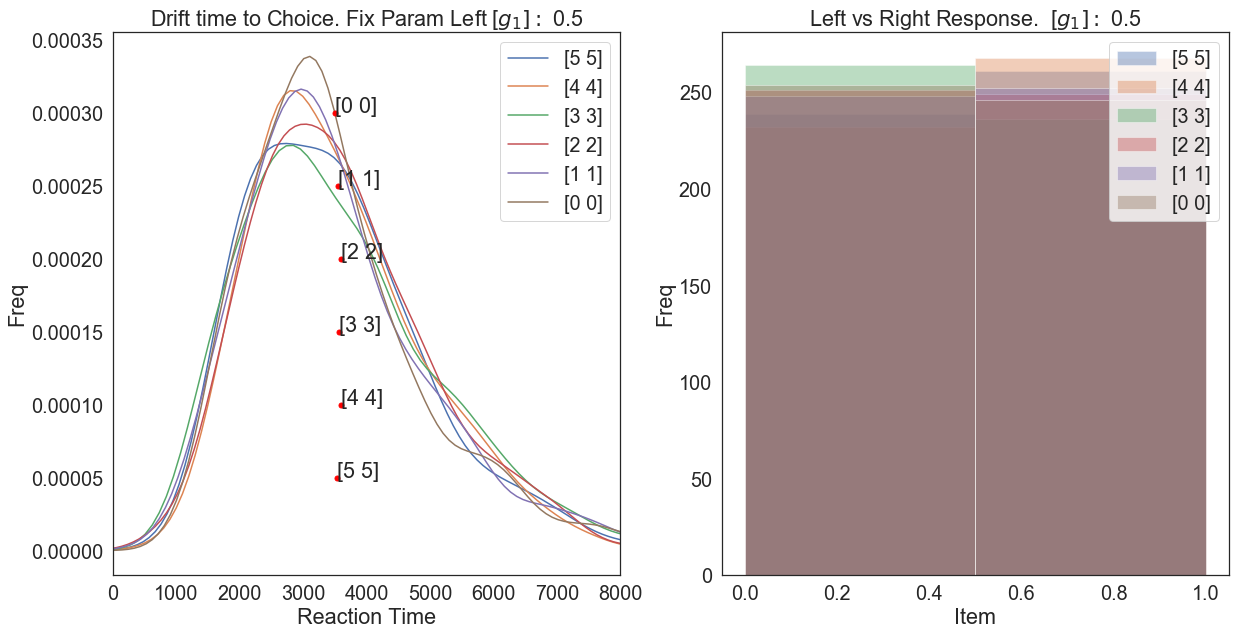

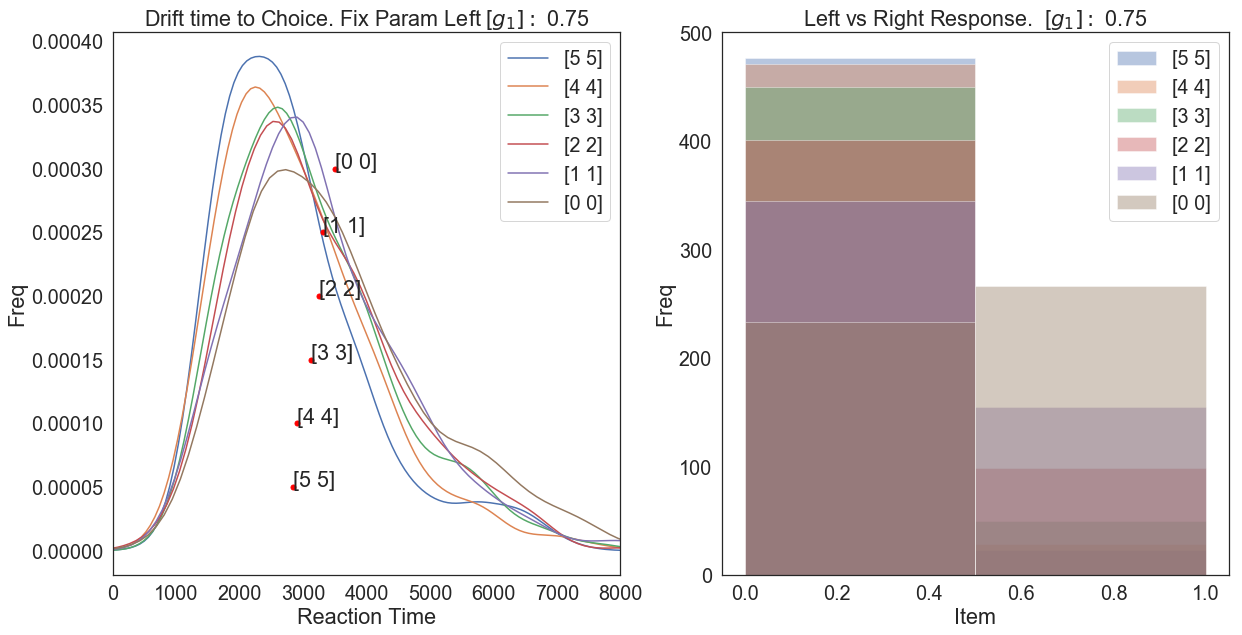

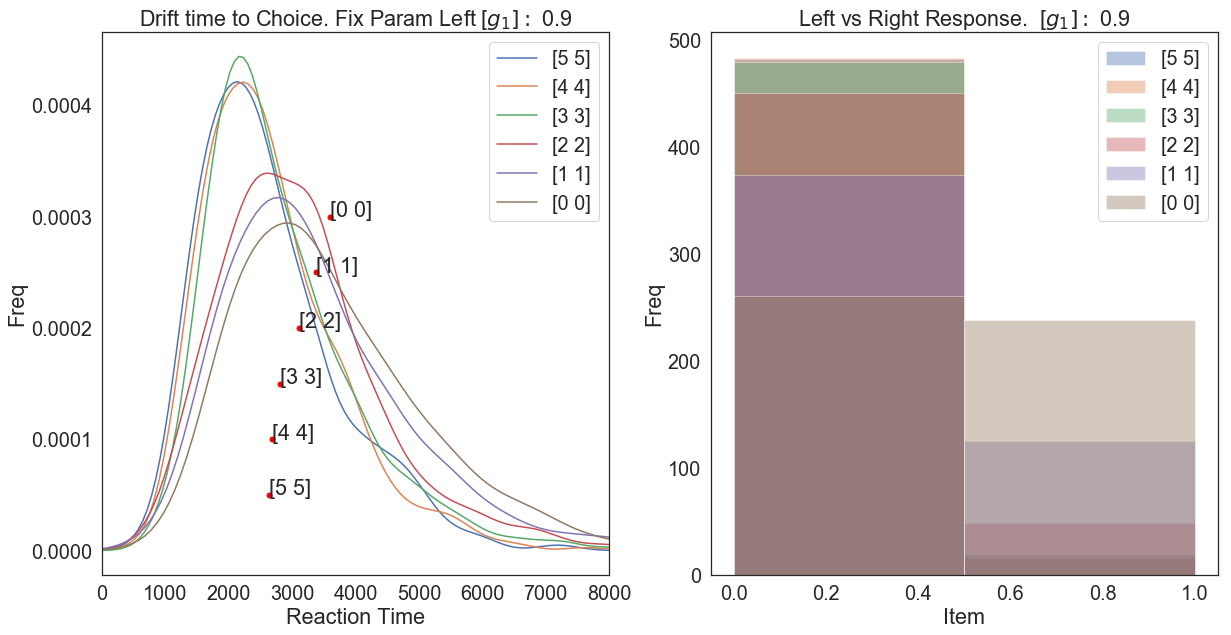

In [18]:
value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 500




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)

    n_trials, n_items = value_tests.shape

    for trial in range(n_trials):
    
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
        # Calculate mean value for reaction times        
        
        mean_rts =  rts.mean()
            
        # Plot for this individual trial
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.plot([mean_rts], [0.00005 + 0.00005*trial], marker='o', markersize=5, color="red")
        plt.text(mean_rts,0.00005 + 0.00005*trial, str(value_trial))
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

                
    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



# Simulations considering various ranges of parameters

## Variation of parameters and gaze ratios

Value for items right/left used : [[5 5]]


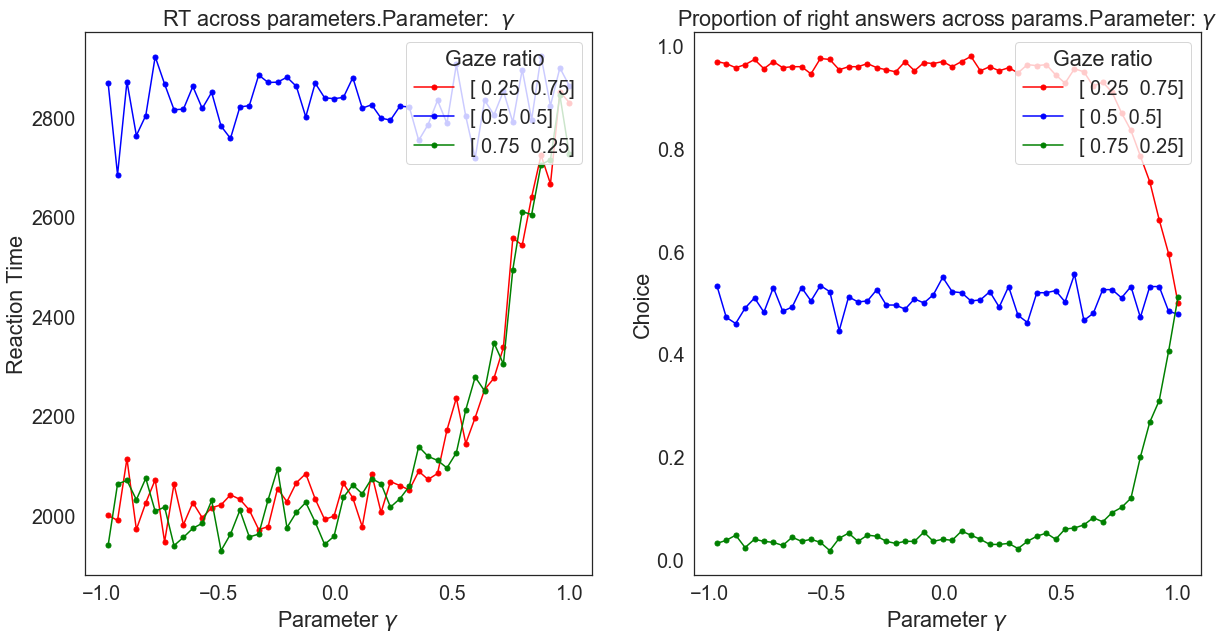

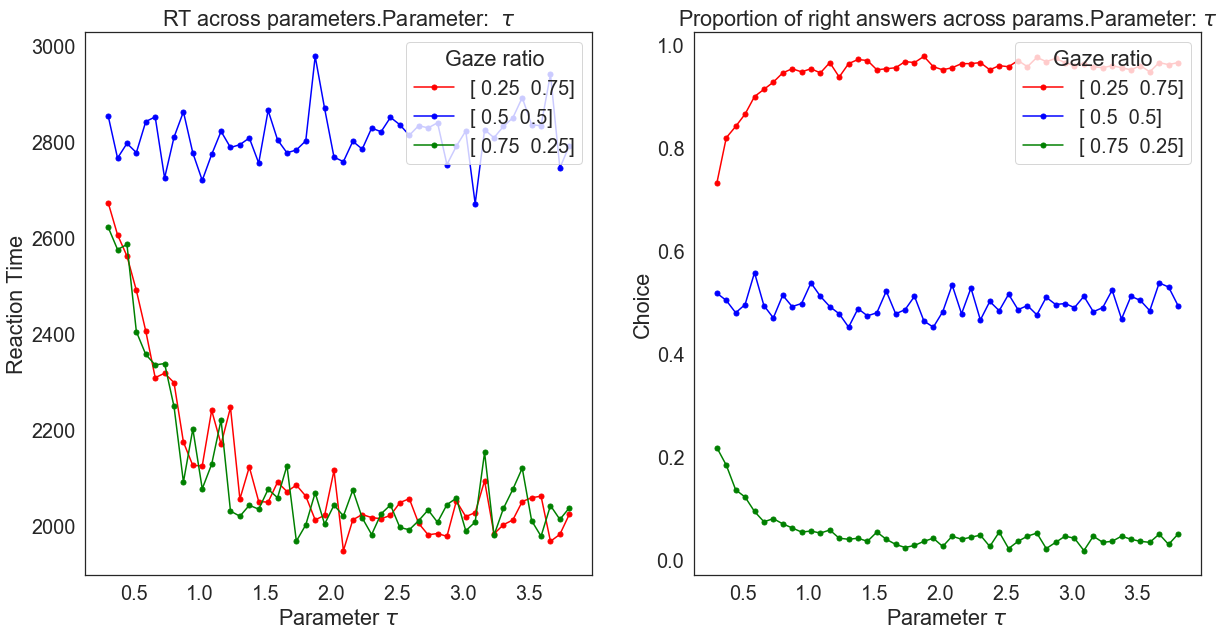

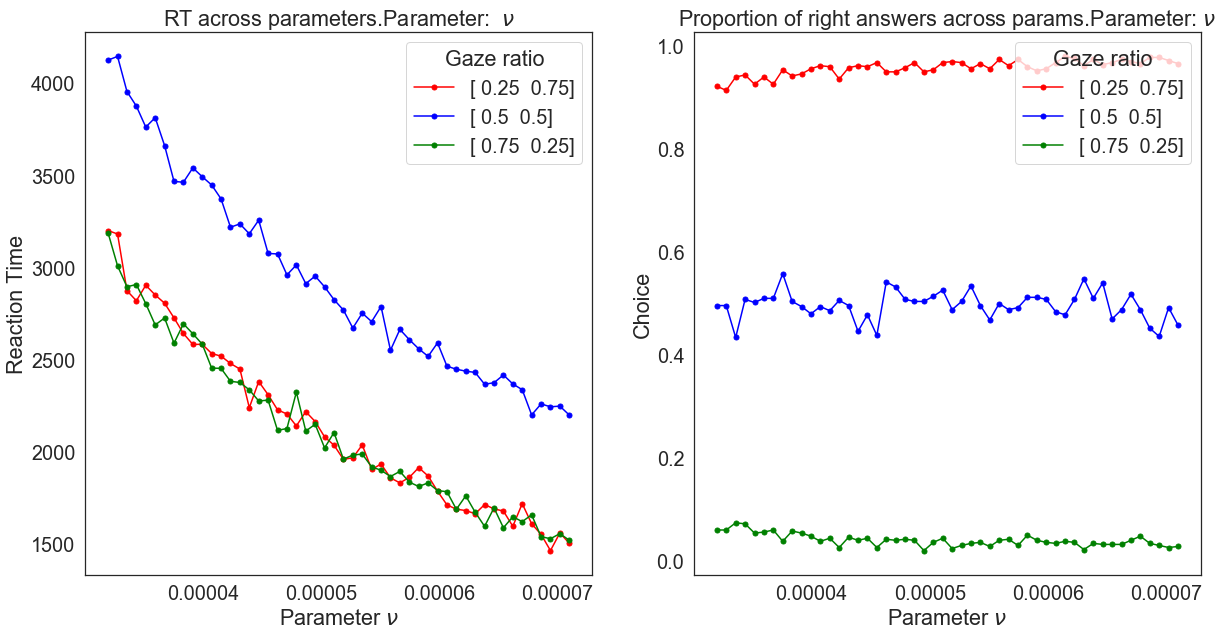

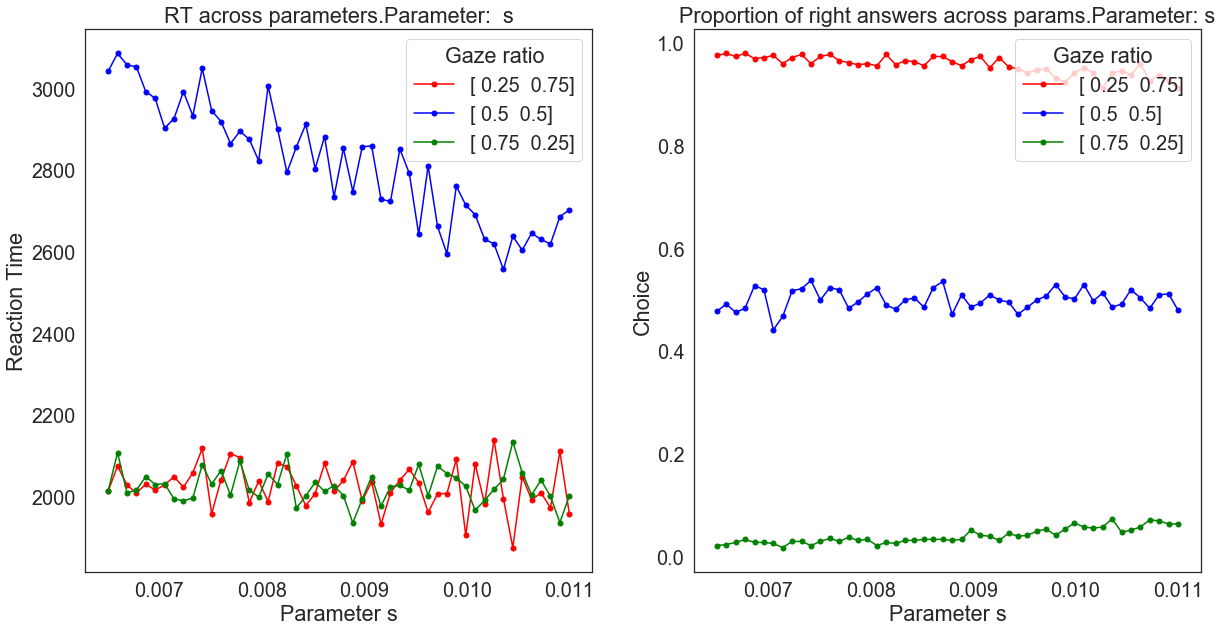

In [21]:
#value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

value_tests = np.array([[5,5]])
print ('Value for items right/left used : ' + str(value_tests))

gaze_tests = np.array([[0.25,0.75],[0.5,0.5],[0.75,0.25]])


# [96 ,170, 230],    # SNR
# Since SNR is calculated  as  v * SNR = s we do not consider it as free paramter

#param_tests = np.array([[-0.97, -0.57, 0.34],  # gamma
#                      [0.30, 1.62, 3.81 ]  ,    # tau
#                       [3.2e-05, 4.9e-05, 7.1e-05 ],  # v
#                       [0.0065, 0.008, 0.011]]  # s
#                      )     
           
param_tests = np.array([np.linspace(-0.97, 1, num = 50),  # gamma
                      np.linspace(0.30, 3.81, num = 50)  ,    # tau
                       np.linspace(3.2e-05, 7.1e-05, num = 50),  # v
                       np.linspace(0.0065, 0.011, num = 50)]  # s
                      )     
middle_point = int(len(param_tests[0])/2)              
rt_min = glam_full.data['rt'][glam_full.data['subject'] == subject].values.min()
rt_max = glam_full.data['rt'][glam_full.data['subject'] == subject].values.max()
error_range = (rt_min, rt_max)
                       

parameters_names = ['$\gamma$', '$\\tau$', '$\\nu$', 's']                  

n_repeats = 500



for param_select in range(param_tests.shape[0]): # iteration for the 4 params
    
    plt.figure(figsize=(20,10));
    sns.set(style='white', font_scale=1.8)

    running_idx_params = 0
    mean_rts_params = np.zeros((gaze_tests.shape[0] ,param_tests.shape[1])) * np.nan
    choice_params = np.zeros((gaze_tests.shape[0],param_tests.shape[1])) * np.nan

    for param_instance_select in range(param_tests.shape[1]): # iteration for (currently) 3 instances (min, median, max) for each parameter
    # we will vary on parameter at a time, we will mantain the rest of paramters constant at the median level.
    
        gamma = param_tests[0][middle_point]
        tau = param_tests[1][middle_point]
        v = param_tests[2][middle_point]
        s = param_tests[3][middle_point]
        t0 = 0
        
        if param_select == 0:  #gamma
                    gamma = param_tests[0][param_instance_select]
        if param_select == 1:  #tau
                    tau = param_tests[1][param_instance_select]
        if param_select == 2:  #v
                    v = param_tests[2][param_instance_select]
        if param_select == 3:  #s
                    s = param_tests[3][param_instance_select]
        
        parameters = [v , gamma, s, tau, t0]
        
        
        
        
        running_idx_gaze = 0

        for gaze_select in range(gaze_tests.shape[0]):
                n_trials, n_items = value_tests.shape
       
                for trial in range(n_trials):
                
                    rts = np.zeros(n_repeats) * np.nan
                    choices = np.zeros(n_repeats) * np.nan
                    trial_idx = np.zeros(n_repeats) * np.nan
                    repeat_idx = np.zeros(n_repeats) * np.nan
                    running_idx = 0
                
                    for repeat in range(n_repeats):
                            
                            value_trial =value_tests[trial]
                            gaze_trial =gaze_tests[gaze_select]
                            
                            choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                                        boundary=boundary,
                                                        error_weight=error_weight,
                                                        error_range=error_range)
                
                            rts[running_idx] = rt
                            choices[running_idx] = choice
                            trial_idx[running_idx] = trial
                            repeat_idx[running_idx] = repeat
                            
                            running_idx += 1
                            
                       
                    # Calculate mean value for reaction times        
                    mean_rts =  rts.mean()              
                    mean_choice =  choices.sum()/choices.size  # choice left : 0 ; choice right : 1   
                    # Add the mean value for this parameters interation               
                    mean_rts_params [running_idx_gaze][running_idx_params] = mean_rts
                    choice_params [running_idx_gaze][running_idx_params] = mean_choice

                    running_idx_gaze += 1 

        
        running_idx_params += 1 
                   
    plt.subplot(121)        
    plt.plot(param_tests[param_select], mean_rts_params[0] , marker='o', markersize=5, color="red");
    plt.plot(param_tests[param_select], mean_rts_params[1] , marker='o', markersize=5, color="blue");
    plt.plot(param_tests[param_select], mean_rts_params[2] , marker='o', markersize=5, color="green");

    plt.title("RT across parameters."+ "Parameter:  " + parameters_names[param_select]);
    plt.ylabel('Reaction Time');
    plt.xlabel('Parameter ' + parameters_names[param_select] );
    plt.legend((str(gaze_tests[0]), str(gaze_tests[1]),str(gaze_tests[2])),loc='upper right', title = 'Gaze ratio');
    plt.subplot(122)
    plt.plot(param_tests[param_select], choice_params[0] , marker='o', markersize=5, color="red");
    plt.plot(param_tests[param_select], choice_params[1] , marker='o', markersize=5, color="blue");
    plt.plot(param_tests[param_select], choice_params[2] , marker='o', markersize=5, color="green");
    plt.title("Proportion of right answers across params."+ "Parameter: " + parameters_names[param_select]);
    plt.ylabel('Choice');
    plt.xlabel('Parameter ' + parameters_names[param_select] );
    plt.legend((str(gaze_tests[0]), str(gaze_tests[1]),str(gaze_tests[2])),loc='upper right', title = 'Gaze ratio');


## Variation of parameters and value

gaze ration right/left used : [[ 0.5  0.5]]


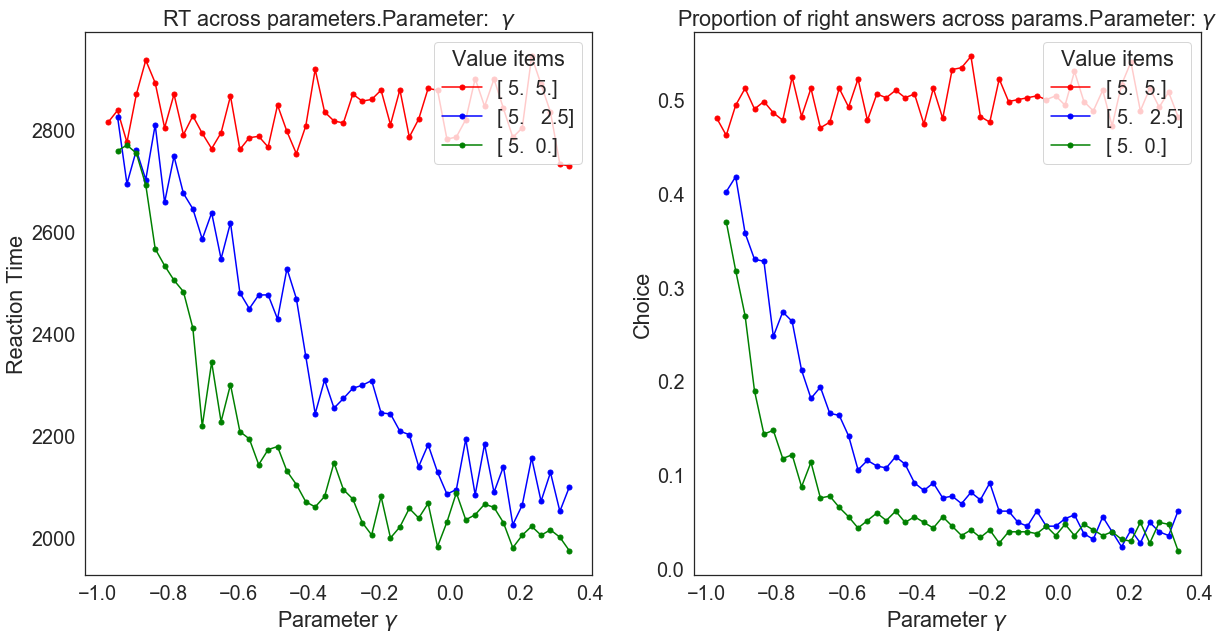

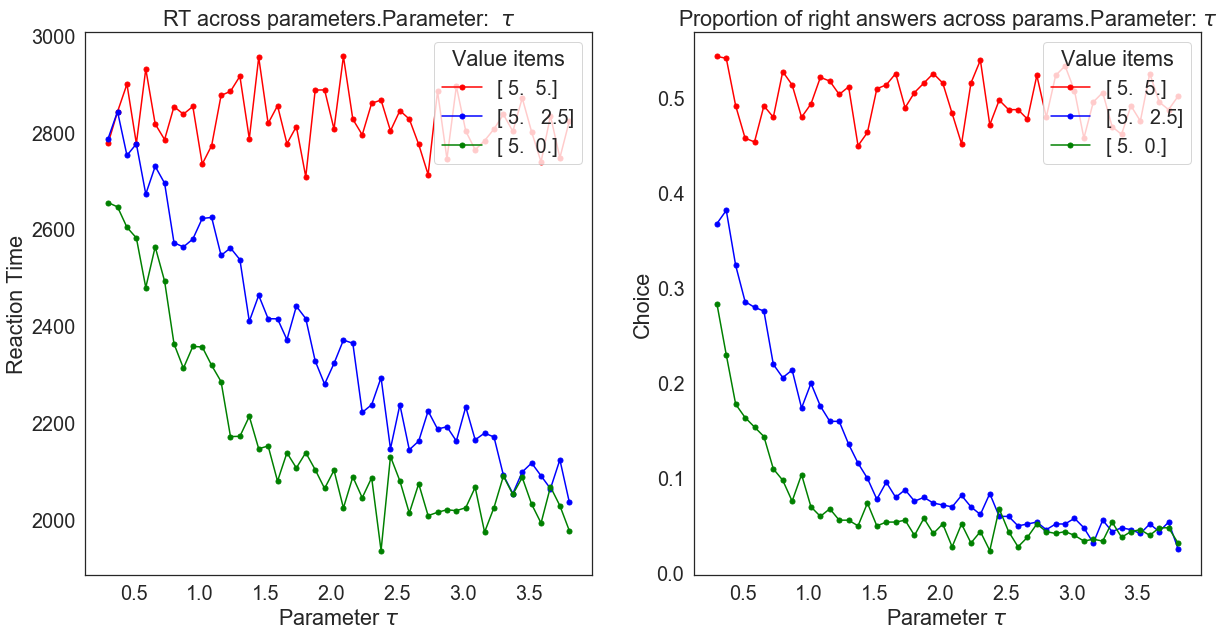

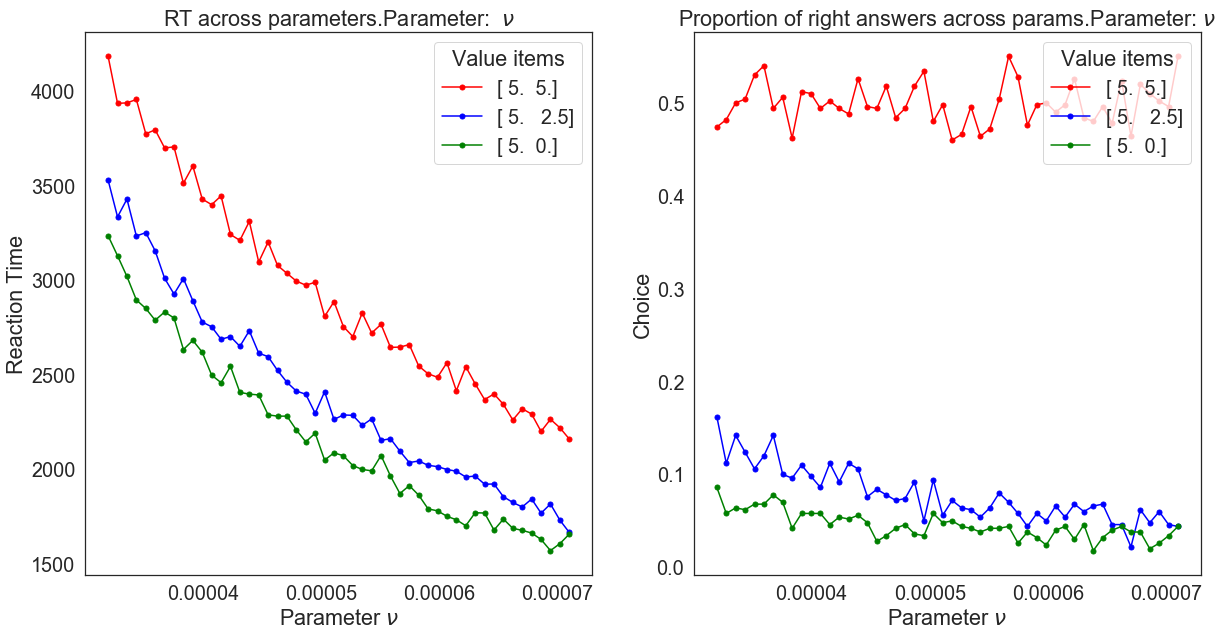

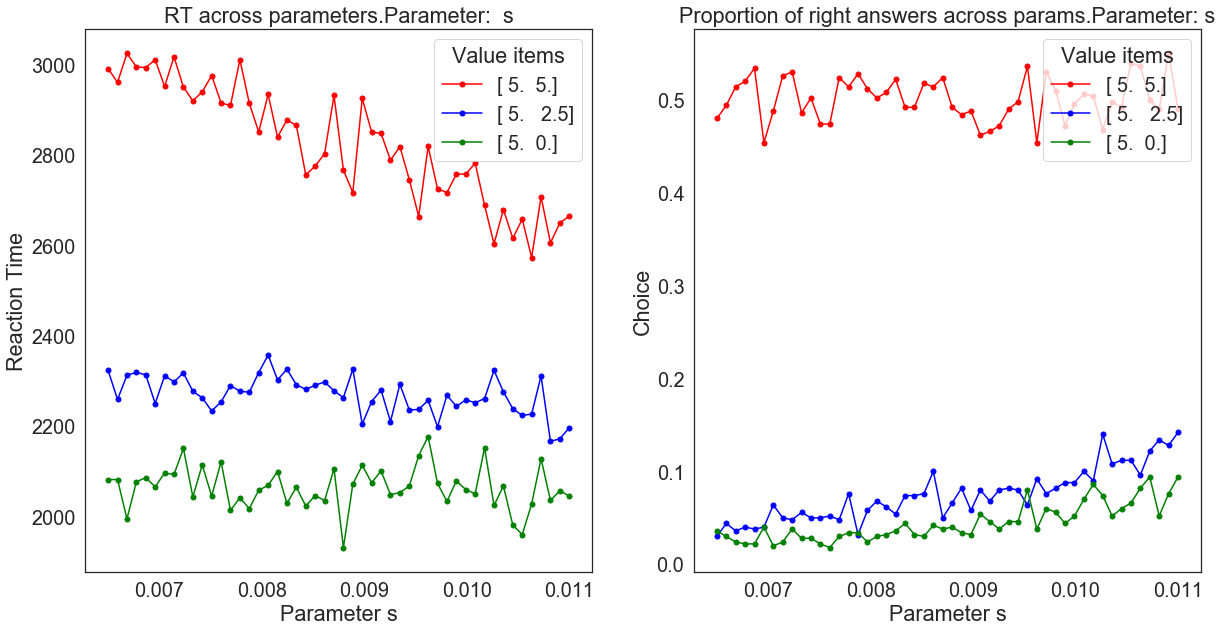

In [20]:
#value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

value_tests = np.array([[5,5],[5,2.5],[5,0]])
gaze_tests = np.array([[0.5,0.5]])

print ('gaze ratio right/left used : ' + str(gaze_tests))



# [96 ,170, 230],    # SNR
# Since SNR is calculated  as  v * SNR = s we do not consider it as free paramter

#param_tests = np.array([[-0.97, -0.57, 0.34],  # gamma
#                      [0.30, 1.62, 3.81 ]  ,    # tau
#                       [3.2e-05, 4.9e-05, 7.1e-05 ],  # v
#                       [0.0065, 0.008, 0.011]]  # s
#                      )     
           
param_tests = np.array([np.linspace(-0.97, 0.34, num = 50),  # gamma
                      np.linspace(0.30, 3.81, num = 50)  ,    # tau
                       np.linspace(3.2e-05, 7.1e-05, num = 50),  # v
                       np.linspace(0.0065, 0.011, num = 50)]  # s
                      )     
middle_point = int(len(param_tests[0])/2)
rt_min = glam_full.data['rt'][glam_full.data['subject'] == subject].values.min()
rt_max = glam_full.data['rt'][glam_full.data['subject'] == subject].values.max()
error_range = (rt_min, rt_max)
                       

parameters_names = ['$\gamma$', '$\\tau$', '$\\nu$', 's']                  

n_repeats = 500



for param_select in range(param_tests.shape[0]): # iteration for the 4 params
    
    plt.figure(figsize=(20,10));
    sns.set(style='white', font_scale=1.8)

    running_idx_params = 0
    mean_rts_params = np.zeros((value_tests.shape[0] ,param_tests.shape[1])) * np.nan
    choice_params = np.zeros((value_tests.shape[0],param_tests.shape[1])) * np.nan

    for param_instance_select in range(param_tests.shape[1]): # iteration for (currently) 3 instances (min, median, max) for each parameter
        # we will vary on parameter at a time, we will mantain the rest of paramters constant at the middle level.
    
        gamma = param_tests[0][middle_point]
        tau = param_tests[1][middle_point]
        v = param_tests[2][middle_point]
        s = param_tests[3][middle_point]
        t0 = 0
        
        if param_select == 0:  #gamma
                    gamma = param_tests[0][param_instance_select]
        if param_select == 1:  #tau
                    tau = param_tests[1][param_instance_select]
        if param_select == 2:  #v
                    v = param_tests[2][param_instance_select]
        if param_select == 3:  #s
                    s = param_tests[3][param_instance_select]
        
        parameters = [v , gamma, s, tau, t0]
        
        
        
        
        running_idx_value = 0
        for trial in range(n_trials):

            
                n_trials, n_items = value_tests.shape

                for gaze_select in range(gaze_tests.shape[0]):
                
                    rts = np.zeros(n_repeats) * np.nan
                    choices = np.zeros(n_repeats) * np.nan
                    trial_idx = np.zeros(n_repeats) * np.nan
                    repeat_idx = np.zeros(n_repeats) * np.nan
                    running_idx = 0
                
                    for repeat in range(n_repeats):
                            
                            value_trial =value_tests[trial]
                            gaze_trial =gaze_tests[gaze_select]
                            
                            choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                                        boundary=boundary,
                                                        error_weight=error_weight,
                                                        error_range=error_range)
                
                            rts[running_idx] = rt
                            choices[running_idx] = choice
                            trial_idx[running_idx] = trial
                            repeat_idx[running_idx] = repeat
                            
                            running_idx += 1
                            
                       
                    # Calculate mean value for reaction times        
                    mean_rts =  rts.mean()              
                    mean_choice =  choices.sum()/choices.size  # choice left : 0 ; choice right : 1   
                    # Add the mean value for this parameters interation               
                    mean_rts_params [running_idx_value][running_idx_params] = mean_rts
                    choice_params [running_idx_value][running_idx_params] = mean_choice

                    running_idx_value += 1 

        
        running_idx_params += 1 
                   
    plt.subplot(121)        
    plt.plot(param_tests[param_select], mean_rts_params[0] , marker='o', markersize=5, color="red");
    plt.plot(param_tests[param_select], mean_rts_params[1] , marker='o', markersize=5, color="blue");
    plt.plot(param_tests[param_select], mean_rts_params[2] , marker='o', markersize=5, color="green");

    plt.title("RT across parameters."+ "Parameter:  " + parameters_names[param_select]);
    plt.ylabel('Reaction Time');
    plt.xlabel('Parameter ' + parameters_names[param_select] );
    plt.legend((str(value_tests[0]), str(value_tests[1]),str(value_tests[2])),loc='upper right', title = 'Value items');
    plt.subplot(122)
    plt.plot(param_tests[param_select], choice_params[0] , marker='o', markersize=5, color="red");
    plt.plot(param_tests[param_select], choice_params[1] , marker='o', markersize=5, color="blue");
    plt.plot(param_tests[param_select], choice_params[2] , marker='o', markersize=5, color="green");
    plt.title("Proportion of right answers across params."+ "Parameter: " + parameters_names[param_select]);
    plt.ylabel('Choice');
    plt.xlabel('Parameter ' + parameters_names[param_select] );
    plt.legend((str(value_tests[0]), str(value_tests[1]),str(value_tests[2])),loc='upper right', title = 'Value items');


## [END]

# JUST SOME PRE-TESTS OF THE CODE

## Using DV = 0 at different value magnitudes

In [ ]:
value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 200




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)


    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



## Attempting to compare between both accumulators

In [ ]:
value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 200




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)


    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        delta_accumulation_time = np.zeros(n_repeats) * np.nan

        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                
                ### Unravelled code for simulate_trial function
                
                v, gamma, s, tau, t0 = parameters
                n_items = len(value_trial)

                if np.random.uniform(0, 1) < error_weight:
                    rt = int(np.random.uniform(*error_range))
                    choice = np.random.choice(n_items)

                else:
                    drifts = glam.simulation.expdrift(v, tau, gamma, value_trial, gaze_trial)

                    FPTs = np.zeros(n_items) * np.nan

                for i in range(n_items):
                    mu = boundary / drifts[i]
                    lam = (boundary / s)**2
                    FPTs[i] = invgauss.rvs(mu=mu/lam, scale=lam)

                choice = np.argmin(FPTs)
                rt = int(np.round(np.min(FPTs) + t0))
                D_acc_time = abs(FPTs[1]-FPTs[0])
                
                #### End of unravelled function
                
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                delta_accumulation_time[running_idx] = D_acc_time
                
                running_idx += 1
                
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        
        plt.subplot(122)
        ax2 =sns.distplot(delta_accumulation_time, hist = False, label=str(value_trial));

        
        #plt.subplot(122)
        #ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Delta Time Hitting the Boundary "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='DTime')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



## Include simulations considering various ranges parameters

In [ ]:
value_tests = np.array([[5,5],[4,4],[3,3],[2,2],[1,1],[0,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])

v , gamma, s, tau, t0 = parameters
gamma = 0.6
tau = 2
parameters = [v , gamma, s, tau, t0]

n_repeats = 500




for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure(figsize=(20,10))
    sns.set(style='white', font_scale=1.8)


    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
                
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
        # Calculate mean value for reaction times        
        
        mean_rts =  rts.mean()
            
        # Plot for this individual trial
        plt.subplot(121)        
        ax1 = sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
        plt.plot([mean_rts], [0.00005 + 0.00005*trial], marker='o', markersize=5, color="red")
        plt.text(mean_rts,0.00005 + 0.00005*trial, str(value_trial))
        plt.subplot(122)
        ax2 =sns.distplot(choices,bins=2, kde = False, hist = True, label=str(value_trial));

                
    #sns.kdeplot(rts)
    
    ax1.set_title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax1.set(ylabel='Freq', xlabel='Reaction Time', xlim = (0, 8000))

    ax2.set_title("Left vs Right Response. "+ " [$g_1 ]:$ " + str(gaze_trial[0]))
    # Set x-axis label
    ax2.set(ylabel='Freq', xlabel='Item')
    #ax2.xticks([0, 1,], ['Left', 'Right'])


    
    ax1.legend();
    ax2.legend();



## Use various differences

In [ ]:
value_tests = np.array([[5,4],[5,3],[5,2],[5,1],[5,0]])
#gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.4,0.6],[0.5,0.5],[0.6, 0.4],[0.75,0.25],[0.9, 0.1]])
gaze_tests = np.array([[0.1,0.9],[0.25,0.75],[0.5,0.5],[0.75,0.25],[0.9, 0.1]])



v , gamma, s, tau, t0 = parameters
tau = 2
gamma = 0.8 


n_repeats = 200


for gaze_select in range(gaze_tests.shape[0]):

    
    plt.figure() 

    for trial in range(n_trials):
    
        n_trials, n_items = value_tests.shape
        rts = np.zeros(n_repeats) * np.nan
        choices = np.zeros(n_repeats) * np.nan
        trial_idx = np.zeros(n_repeats) * np.nan
        repeat_idx = np.zeros(n_repeats) * np.nan
        running_idx = 0
    
        for repeat in range(n_repeats):
                
                value_trial =value_tests[trial]
                gaze_trial =gaze_tests[gaze_select]
    
                choice, rt = glam.simulation.simulate_trial(parameters, value_trial, gaze_trial,
                                            boundary=boundary,
                                            error_weight=error_weight,
                                            error_range=error_range)
    
                rts[running_idx] = rt
                choices[running_idx] = choice
                trial_idx[running_idx] = trial
                repeat_idx[running_idx] = repeat
                
                running_idx += 1
                
        sns.distplot(rts, bins=10, rug=False, hist = False, label=str(value_trial),);
    #sns.kdeplot(rts)
    
    plt.title("Drift time to Choice. Fix Param Left"+ " [$g_1 ]:$ " + str(gaze_trial[0]) )
    # Set x-axis label
    plt.xlabel('Reaction Time')
    # Set y-axis label
    plt.ylabel('Freq')
    plt.xlim(0, 8000)

    
    plt.legend();
    


In [ ]:

# only one trial simulation
value_trial = np.array([5,4])
gaze_trial =np.array([0.76233184,  0.23766816])

v, gamma, s, tau, t0 = parameters
n_items = len(values[trial])

choice, rt = glam.simulation.simulate_trial(parameters,value_trial , gaze_trial,
                                        boundary=boundary,
                                        error_weight=error_weight,
                                        error_range=error_range)

## Attempt with hierarchical model data

In [ ]:
test_data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
train_data = pd.read_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))

In [ ]:
glam_full = glam.GLAM(train_data)
glam_full.make_model('individual', gamma_bounds=(-1, 1), t0_val=0)
glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))   


In [ ]:

glam_full.exchange_data(test_data)


In [ ]:
glam_full.estimates


In [ ]:
subjects = np.unique(glam_full.data['subject'])
subjects

In [ ]:
glam_full.predict(n_repeats=50)
#glam.full.estimates

In [ ]:
glam_full.estimates.get('v')

In [ ]:
glam_full.prediction = pd.read_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'))

test_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))